# Telco Customer Churn
[Link](https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data) to the dataset

The goal of that research is to build a model that predicts the likelihood of telecommunication customers ending
their subscription (churning) based on their historical data (e.g. demographic, account, service usage, etc...)

This prediction should help a marketing team devise targeted interventions to retain customers at risk of churning,
which might involve offering special promotions, addressing service pain points, etc...


## Requirements
Imports, constants, etc.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from polars.testing import assert_frame_equal
from scipy.stats import mannwhitneyu
from scipy.stats._mannwhitneyu import MannwhitneyuResult

from telco_customer_churn import DATA_DIR

CASTED_DATA_PATH = DATA_DIR / "processed_data" / "telco_customer_churn_cleaned.parquet"


## Data downloading

In [2]:
raw_data_path = DATA_DIR / "raw_data" / "telco-customer-churn.csv"

if not raw_data_path.exists():
    print("Downloading the raw data...")
    raw_zip_path = DATA_DIR / "raw_data" / "telco-customer-churn.zip"
    raw_zip_path.parent.mkdir(parents=True, exist_ok=True)

    !curl -L -o {raw_zip_path} https://www.kaggle.com/api/v1/datasets/download/blastchar/telco-customer-churn
    !unzip {raw_zip_path} -d {DATA_DIR / "raw_data"}
    !rm {raw_zip_path}

    raw_csv_path = next(iter((DATA_DIR / "raw_data").glob("*.csv")))
    raw_csv_path.rename(raw_data_path)
    print("Raw data downloaded and saved to the data directory.")
else:
    print("Raw data already exists in the data directory.")

f"Path to the raw data: {raw_data_path}"

Raw data already exists in the data directory.


'Path to the raw data: /home/ignat/projects/telco_customer_churn/data/raw_data/telco-customer-churn.csv'

## First glance
In this section I will read the file and make a brief overview of the data.

In [3]:
raw_lf = pl.scan_csv(raw_data_path)
f"Shape of the raw data: {raw_lf.collect().shape}"

'Shape of the raw data: (7043, 21)'

In [4]:
print("Column names and types:")
for col, typ in raw_lf.collect().schema.items():
    print(f"  - {col}: {typ}")

Column names and types:
  - customerID: String
  - gender: String
  - SeniorCitizen: Int64
  - Partner: String
  - Dependents: String
  - tenure: Int64
  - PhoneService: String
  - MultipleLines: String
  - InternetService: String
  - OnlineSecurity: String
  - OnlineBackup: String
  - DeviceProtection: String
  - TechSupport: String
  - StreamingTV: String
  - StreamingMovies: String
  - Contract: String
  - PaperlessBilling: String
  - PaymentMethod: String
  - MonthlyCharges: Float64
  - TotalCharges: Float64
  - Churn: String


In [5]:
raw_lf.collect().head()

customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
str,str,i64,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str
"""7590-VHVEG""","""Female""",0,"""Yes""","""No""",1,"""No""","""No phone service""","""DSL""","""No""","""Yes""","""No""","""No""","""No""","""No""","""Month-to-month""","""Yes""","""Electronic check""",29.85,29.85,"""No"""
"""5575-GNVDE""","""Male""",0,"""No""","""No""",34,"""Yes""","""No""","""DSL""","""Yes""","""No""","""Yes""","""No""","""No""","""No""","""One year""","""No""","""Mailed check""",56.95,1889.5,"""No"""
"""3668-QPYBK""","""Male""",0,"""No""","""No""",2,"""Yes""","""No""","""DSL""","""Yes""","""Yes""","""No""","""No""","""No""","""No""","""Month-to-month""","""Yes""","""Mailed check""",53.85,108.15,"""Yes"""
"""7795-CFOCW""","""Male""",0,"""No""","""No""",45,"""No""","""No phone service""","""DSL""","""Yes""","""No""","""Yes""","""Yes""","""No""","""No""","""One year""","""No""","""Bank transfer (automatic)""",42.3,1840.75,"""No"""
"""9237-HQITU""","""Female""",0,"""No""","""No""",2,"""Yes""","""No""","""Fiber optic""","""No""","""No""","""No""","""No""","""No""","""No""","""Month-to-month""","""Yes""","""Electronic check""",70.7,151.65,"""Yes"""


Check for constant columns

In [6]:
has_constant_cols = False
for col in raw_lf.collect_schema().keys():
    if raw_lf.select(pl.col(col).n_unique() == 1).collect().item():
        print(f"{col} is a constant column")
        has_constant_cols = True
if not has_constant_cols:
    print("No constant columns found")


No constant columns found


Describe the whole dataset.

In [7]:
raw_lf.describe()

statistic,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
str,str,str,f64,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str
"""count""","""7043""","""7043""",7043.0,"""7043""","""7043""",7043.0,"""7043""","""7043""","""7043""","""7043""","""7043""","""7043""","""7043""","""7043""","""7043""","""7043""","""7043""","""7043""",7043.0,7032.0,"""7043"""
"""null_count""","""0""","""0""",0.0,"""0""","""0""",0.0,"""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""",0.0,11.0,"""0"""
"""mean""",null,null,0.162147,null,null,32.371149,null,null,null,null,null,null,null,null,null,null,null,null,64.761692,2283.300441,null
"""std""",null,null,0.368612,null,null,24.559481,null,null,null,null,null,null,null,null,null,null,null,null,30.090047,2266.771362,null
"""min""","""0002-ORFBO""","""Female""",0.0,"""No""","""No""",0.0,"""No""","""No""","""DSL""","""No""","""No""","""No""","""No""","""No""","""No""","""Month-to-month""","""No""","""Bank transfer (automatic)""",18.25,18.8,"""No"""
"""25%""",null,null,0.0,null,null,9.0,null,null,null,null,null,null,null,null,null,null,null,null,35.5,401.5,null
"""50%""",null,null,0.0,null,null,29.0,null,null,null,null,null,null,null,null,null,null,null,null,70.35,1397.65,null
"""75%""",null,null,0.0,null,null,55.0,null,null,null,null,null,null,null,null,null,null,null,null,89.85,3794.5,null
"""max""","""9995-HOTOH""","""Male""",1.0,"""Yes""","""Yes""",72.0,"""Yes""","""Yes""","""No""","""Yes""","""Yes""","""Yes""","""Yes""","""Yes""","""Yes""","""Two year""","""Yes""","""Mailed check""",118.75,8684.8,"""Yes"""


"TotalCharges" column has 11 nulls. I think they are the new clients. Check that.

In [8]:
max_tenure = raw_lf.filter(pl.col("TotalCharges").is_null()).select(pl.col("tenure").max()).collect().item()
print(f"Max tenure of the clients with null TotalCharges: {max_tenure}")

zero_tenure_total_charges = (
    raw_lf
    .filter(pl.col("tenure") == 0)
    .select(
        pl.col("TotalCharges").unique().alias("TotalCharges of new clients")
    )
    .collect()
)
zero_tenure_total_charges

Max tenure of the clients with null TotalCharges: 0


TotalCharges of new clients
f64
null


We can replace nulls in the "TotalCharges" column with 0.

Also, `SeniorCitizen` column looks boolean.

In [9]:
raw_lf.group_by("SeniorCitizen").count().collect()

/tmp/ipykernel_12168/2200488246.py:1: DeprecationWarning: `LazyGroupBy.count` is deprecated. It has been renamed to `len`.
  raw_lf.group_by("SeniorCitizen").count().collect()


SeniorCitizen,count
i64,u32
1,1142
0,5901


## Data cleaning
Handle missing values and correct data types for string columns.

First, get all unique values of each column to identify boolean columns.

In [10]:
str_cols = [col for col, typ in raw_lf.collect_schema().items() if isinstance(typ, pl.String)]
boolean_cols, constant_cols, unique_id_cols, categorical_cols = [], [], [], []
for col in str_cols:
    unique_values = list(raw_lf.select(pl.col(col).unique()).collect().to_series())
    n_unique = len(unique_values)
    if n_unique == 2:
        boolean_cols.append(col)
        print(f"{col} is a boolean column; values: {unique_values}")
    elif n_unique == 1:
        constant_cols.append(col)
        print(f"{col} is a constant column; value: {unique_values[0]}")
    elif n_unique == raw_lf.collect().shape[0]:
        unique_id_cols.append(col)
        print(f"{col} is a unique identifier column")
    else:
        categorical_cols.append(col)
        print(f"{col}: {n_unique} unique values; values: {unique_values}")

customerID is a unique identifier column
gender is a boolean column; values: ['Female', 'Male']
Partner is a boolean column; values: ['No', 'Yes']
Dependents is a boolean column; values: ['Yes', 'No']
PhoneService is a boolean column; values: ['Yes', 'No']
MultipleLines: 3 unique values; values: ['Yes', 'No phone service', 'No']
InternetService: 3 unique values; values: ['DSL', 'Fiber optic', 'No']
OnlineSecurity: 3 unique values; values: ['No internet service', 'Yes', 'No']
OnlineBackup: 3 unique values; values: ['No', 'No internet service', 'Yes']
DeviceProtection: 3 unique values; values: ['No', 'No internet service', 'Yes']
TechSupport: 3 unique values; values: ['No', 'Yes', 'No internet service']
StreamingTV: 3 unique values; values: ['No internet service', 'No', 'Yes']
StreamingMovies: 3 unique values; values: ['No', 'No internet service', 'Yes']
Contract: 3 unique values; values: ['One year', 'Month-to-month', 'Two year']
PaperlessBilling is a boolean column; values: ['No', 'Yes

Some features have "No internet service" and "No phone service" values. We can cast these features to boolean and create a separate features "has_internet_service" and "has_phone_service".

"InternetService" variable has value "No". Check if it's the same as "No internet service".

In [11]:
no_internet_service_features = [
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
]

no_phone_service_features = ["MultipleLines"]

# Check no internet service features are the same
no_internet_service = raw_lf.filter(pl.col(no_internet_service_features[0]) == "No internet service")
for feature in no_internet_service_features[1:]:
    no_internet_feature = raw_lf.filter(pl.col(feature) == "No internet service")
    pl.testing.assert_frame_equal(no_internet_service, no_internet_feature)

# Check InternetService == No
internet_service_no = raw_lf.filter(pl.col("InternetService") == "No")
pl.testing.assert_frame_equal(no_internet_service, internet_service_no)


InternetService can be cast to boolean "is_fiber".

Clean the dataset:
- drop ID column;
- cast boolean columns;
- cast categorical columns;
- replace nulls in TotalCharges column;
- cast SeniorCitizen to boolean;
- create separate columns for "has_internet_service" and "has_phone_service";
- make the next columns boolean: "MultipleLines", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies";
- cast "InternetService" to "is_fiber".

In [12]:
import pandas as pd


def visualize_categorical_vs_boolean(df, cat_var, bool_var, figsize=(15, 10)):
    """Comprehensive visualization of categorical vs boolean relationships.

    Args:
        df: DataFrame with the data
        cat_var: Name of categorical variable
        bool_var: Name of boolean variable
        figsize: Figure size tuple
    """
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle(f'Relationship between {cat_var} and {bool_var}', fontsize=16)

    # 1. Stacked Bar Chart (Proportions)
    contingency = pd.crosstab(df[cat_var], df[bool_var], normalize='index')
    contingency.plot(kind='bar', stacked=True, ax=axes[0,0],
                    color=['lightcoral', 'skyblue'])
    axes[0,0].set_title('Proportions (Stacked Bar)')
    axes[0,0].set_ylabel('Proportion')
    axes[0,0].legend(['False', 'True'])
    axes[0,0].tick_params(axis='x', rotation=45)

    # 2. Grouped Bar Chart (Counts)
    contingency_counts = pd.crosstab(df[cat_var], df[bool_var])
    contingency_counts.plot(kind='bar', ax=axes[0,1],
                           color=['lightcoral', 'skyblue'])
    axes[0,1].set_title('Counts (Grouped Bar)')
    axes[0,1].set_ylabel('Count')
    axes[0,1].legend(['False', 'True'])
    axes[0,1].tick_params(axis='x', rotation=45)

    # 3. Heatmap of proportions
    sns.heatmap(contingency, annot=True, fmt='.2%', cmap='RdYlBu_r',
                ax=axes[1,0], cbar_kws={'label': 'Proportion'})
    axes[1,0].set_title('Heatmap (Proportions)')

    # 4. Point plot with confidence intervals
    # Convert boolean to numeric for pointplot
    df_temp = df.copy()
    df_temp[f'{bool_var}_numeric'] = df_temp[bool_var].astype(int)

    sns.pointplot(data=df_temp, x=cat_var, y=f'{bool_var}_numeric',
                  ax=axes[1,1], ci=95, color='darkblue')
    axes[1,1].set_title('Rate with 95% CI')
    axes[1,1].set_ylabel(f'{bool_var} Rate')
    axes[1,1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print(f"\n=== Summary: {cat_var} vs {bool_var} ===")
    print("Proportions:")
    print(contingency.round(3))
    print("\nCounts:")
    print(contingency_counts)
    print(f"\nOverall {bool_var} rate: {df[bool_var].mean():.3f}")


In [13]:
def cast_to_bool(lf: pl.LazyFrame) -> pl.LazyFrame:
    """Cast boolean features to boolean format."""
    return (
        lf
        .with_columns(
            (pl.col("gender") == "Male").alias("is_male"),
            (pl.col("Partner") == "Yes").alias("has_partner"),
            (pl.col("Dependents") == "Yes").alias("has_dependents"),
            (pl.col("PhoneService") == "Yes").alias("has_phone_service"),
            (pl.col("PaperlessBilling") == "Yes").alias("is_paperless_billing"),
            (pl.col("Churn") == "Yes").alias("is_churned"),
            (pl.col("SeniorCitizen") == 1).alias("is_senior_citizen"),
        )
        .drop(boolean_cols + ["SeniorCitizen"])
    )

def create_bool_features(lf: pl.LazyFrame) -> pl.LazyFrame:
    """Create special boolean features from categorical features."""
    return lf.with_columns(
        (pl.col("InternetService") != "No").alias("has_internet_service"),
        (pl.col("MultipleLines") != "No phone service").alias("has_multiple_lines"),
    )

def cast_cat_to_bool(lf: pl.LazyFrame) -> pl.LazyFrame:
    """Cast categorical features to boolean format."""
    return (
        lf
        .with_columns(
            (pl.col("InternetService") == "Fiber optic").alias("is_fiber"),
            (pl.col("MultipleLines") == "Yes").alias("has_multiple_lines"),
            (pl.col("OnlineSecurity") == "Yes").alias("has_online_security"),
            (pl.col("OnlineBackup") == "Yes").alias("has_online_backup"),
            (pl.col("DeviceProtection") == "Yes").alias("has_device_protection"),
            (pl.col("TechSupport") == "Yes").alias("has_tech_support"),
            (pl.col("StreamingTV") == "Yes").alias("has_streaming_tv"),
            (pl.col("StreamingMovies") == "Yes").alias("has_streaming_movies"),
        )
        .drop([
            "InternetService",
            "MultipleLines",
            "OnlineSecurity",
            "OnlineBackup",
            "DeviceProtection",
            "TechSupport",
            "StreamingTV",
            "StreamingMovies",
        ])
    )

def cast_to_categorical(lf: pl.LazyFrame) -> pl.LazyFrame:
    """Cast categorical features to categorical format."""
    cat_cols = ["Contract", "PaymentMethod"]
    return lf.with_columns(
        pl.col(col).cast(pl.Categorical) for col in cat_cols
    )

dt_casted_lf = (
    raw_lf
    .drop(unique_id_cols)
    .drop(constant_cols)
    .pipe(cast_to_bool)
    .pipe(create_bool_features)
    .pipe(cast_cat_to_bool)
    .pipe(cast_to_categorical)
    .with_columns(pl.col("TotalCharges").fill_null(0))
)

dt_casted_lf.collect().head()

tenure,Contract,PaymentMethod,MonthlyCharges,TotalCharges,is_male,has_partner,has_dependents,has_phone_service,is_paperless_billing,is_churned,is_senior_citizen,has_internet_service,has_multiple_lines,is_fiber,has_online_security,has_online_backup,has_device_protection,has_tech_support,has_streaming_tv,has_streaming_movies
i64,cat,cat,f64,f64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool
1,"""Month-to-month""","""Electronic check""",29.85,29.85,false,true,false,false,true,false,false,true,false,false,false,true,false,false,false,false
34,"""One year""","""Mailed check""",56.95,1889.5,true,false,false,true,false,false,false,true,false,false,true,false,true,false,false,false
2,"""Month-to-month""","""Mailed check""",53.85,108.15,true,false,false,true,true,true,false,true,false,false,true,true,false,false,false,false
45,"""One year""","""Bank transfer (automatic)""",42.3,1840.75,true,false,false,false,false,false,false,true,false,false,true,false,true,true,false,false
2,"""Month-to-month""","""Electronic check""",70.7,151.65,false,false,false,true,true,true,false,true,false,true,false,false,false,false,false,false


In [14]:
CASTED_DATA_PATH.parent.mkdir(parents=True, exist_ok=True)
dt_casted_lf.collect().write_parquet(CASTED_DATA_PATH)

dt_casted_lf_from_file = pl.scan_parquet(CASTED_DATA_PATH)
assert_frame_equal(dt_casted_lf.collect(), dt_casted_lf_from_file.collect())
del dt_casted_lf_from_file

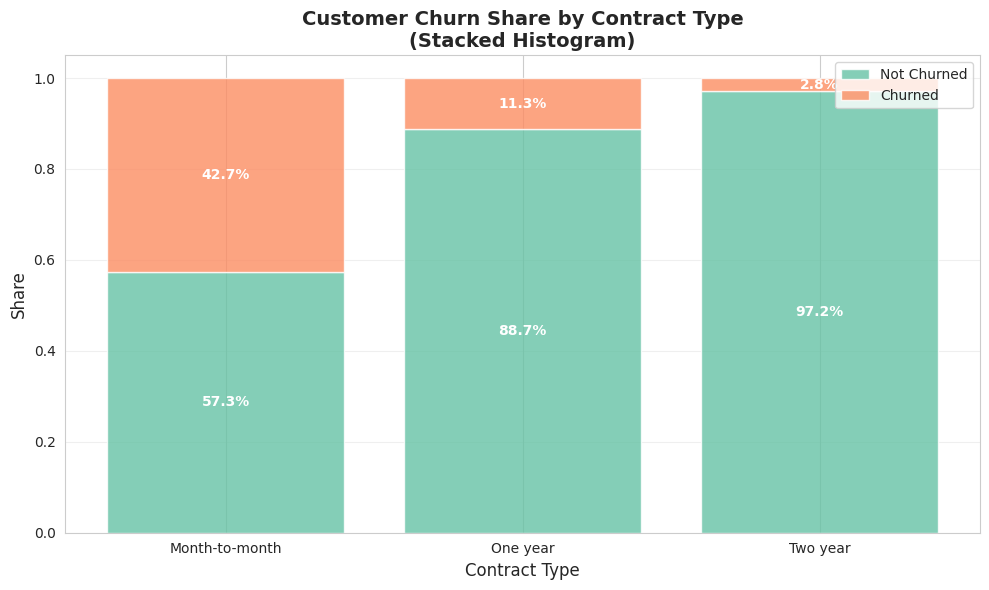

Churn rates by contract type:
  Month-to-month: 42.7% churn rate
  One year: 11.3% churn rate
  Two year: 2.8% churn rate


In [15]:
# Create stacked histogram showing churn share by contract type
feature = "Contract"
churn_data = dt_casted_lf.group_by(feature).agg(pl.col("is_churned").mean().alias("is_churned_share")).collect()

# Prepare data for stacked bar chart
contracts = churn_data["Contract"].to_list()
churned_share = churn_data["is_churned_share"].to_list()
not_churned_share = [1 - churn for churn in churned_share]

# Set seaborn style and get color palette
sns.set_style("whitegrid")
colors = sns.color_palette("Set2", 2)  # Get 2 colors from Set2 palette
retained_color = colors[0]  # First color for retained customers
churned_color = colors[1]   # Second color for churned customers

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Create stacked bars with seaborn colors
bars1 = ax.bar(contracts, not_churned_share, label='Not Churned', color=retained_color, alpha=0.8)
bars2 = ax.bar(contracts, churned_share, bottom=not_churned_share, label='Churned', color=churned_color, alpha=0.8)

# Customize the plot
ax.set_ylabel('Share', fontsize=12)
ax.set_xlabel('Contract Type', fontsize=12)
ax.set_title('Customer Churn Share by Contract Type\n(Stacked Histogram)', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(axis='y', alpha=0.3)

# Add percentage labels on bars
for i, churn_rate in enumerate(churned_share):
    # Churn rate label (on the churned portion)
    ax.text(i, not_churned_share[i] + churn_rate/2, f'{churn_rate:.1%}',
            ha='center', va='center', fontweight='bold', color='white')
    # Retention rate label (on the retained portion)
    ax.text(i, not_churned_share[i]/2, f'{not_churned_share[i]:.1%}',
            ha='center', va='center', fontweight='bold', color='white')

plt.tight_layout()
plt.show()

# Print the data for reference
print("Churn rates by contract type:")
for contract, rate in zip(contracts, churned_share):
    print(f"  {contract}: {rate:.1%} churn rate")


Checkpoint: cleaned dataset.

In [16]:
dt_casted_lf = pl.scan_parquet(CASTED_DATA_PATH)

## EDA
Analyze data distributions, identify patterns, and understand relationships between features.

#### Check the distribution of the target variable (churn)

shape: (2, 2)
┌────────────┬─────────┐
│ is_churned ┆ share   │
│ ---        ┆ ---     │
│ bool       ┆ f64     │
╞════════════╪═════════╡
│ false      ┆ 0.73463 │
│ true       ┆ 0.26537 │
└────────────┴─────────┘


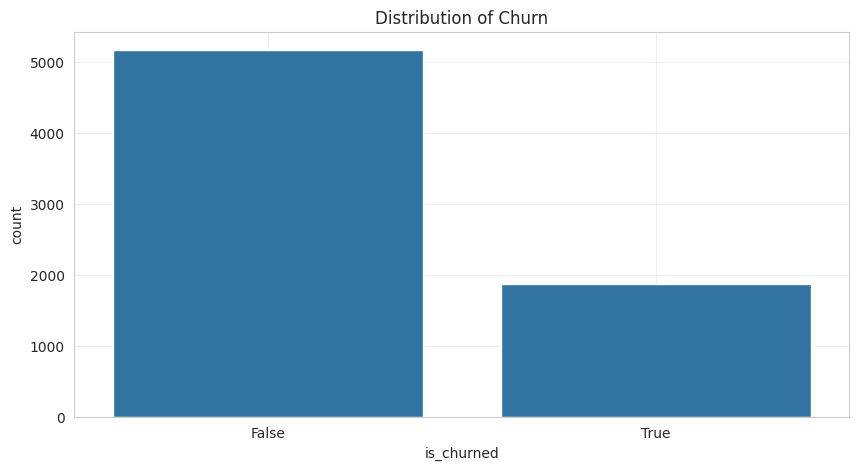

In [17]:
lf_len = dt_casted_lf.select(pl.len()).collect().item()
print(
    dt_casted_lf
    .group_by("is_churned")
    .agg((pl.len() / lf_len).alias("share"))
    .collect()
)

plt.figure(figsize=(10, 5))
sns.countplot(x=dt_casted_lf.select("is_churned").collect().to_series())
plt.title("Distribution of Churn")
plt.grid(alpha=0.3)
plt.show()


The dataset is imbalanced.

### Numeric Features
#### Visualize the distribution of numeric features
Numeric features are `tenure`, `MonthlyCharges`, `TotalCharges`

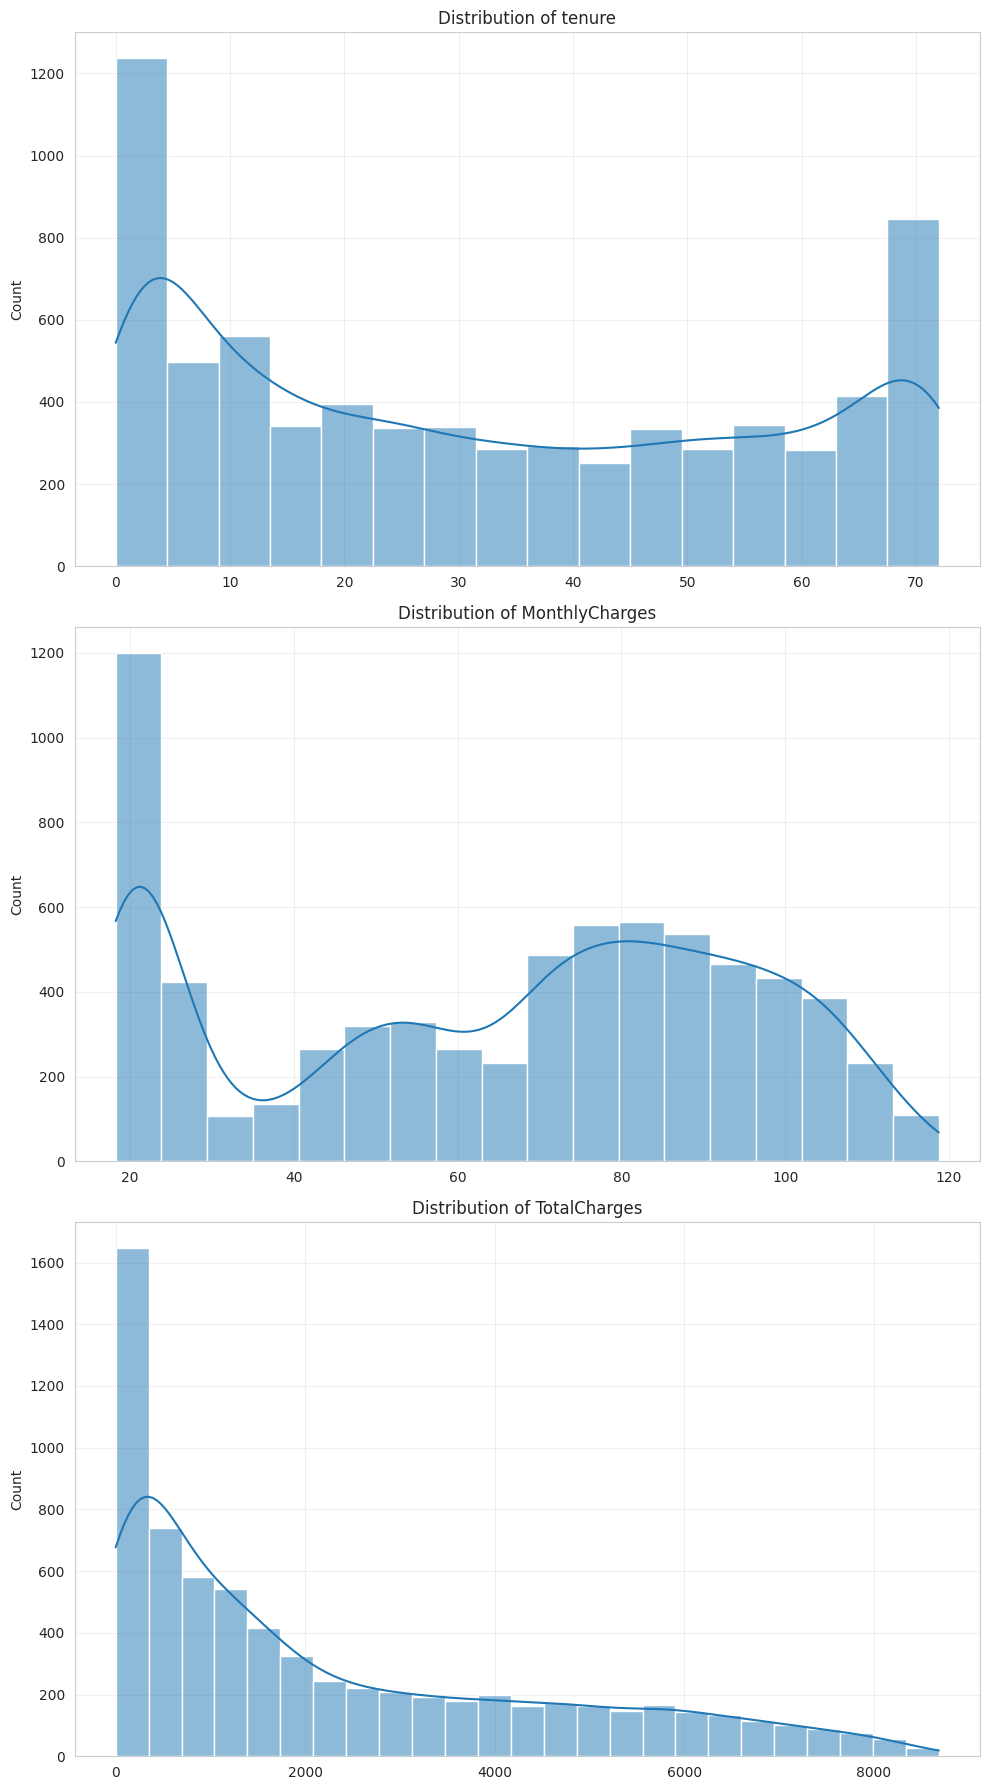

In [18]:
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
fig, axes = plt.subplots(len(numeric_features), 1, figsize=(10, 18))
for i, feature in enumerate(numeric_features):
    data = dt_casted_lf.select(feature).collect().to_series()
    sns.histplot(data=data, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].grid(alpha=0.3)
plt.tight_layout()
plt.show()

A couple of insights:
1. Most of the customers are either new or very old (>=65 months).
2. The most of the customers pay no more than $30 per month. But there are two significant groups of payers: middle (~$50) and big (>$70).
3. The distribution of TotalCharges is right skewed.

Visualize the relationship between X and churn.

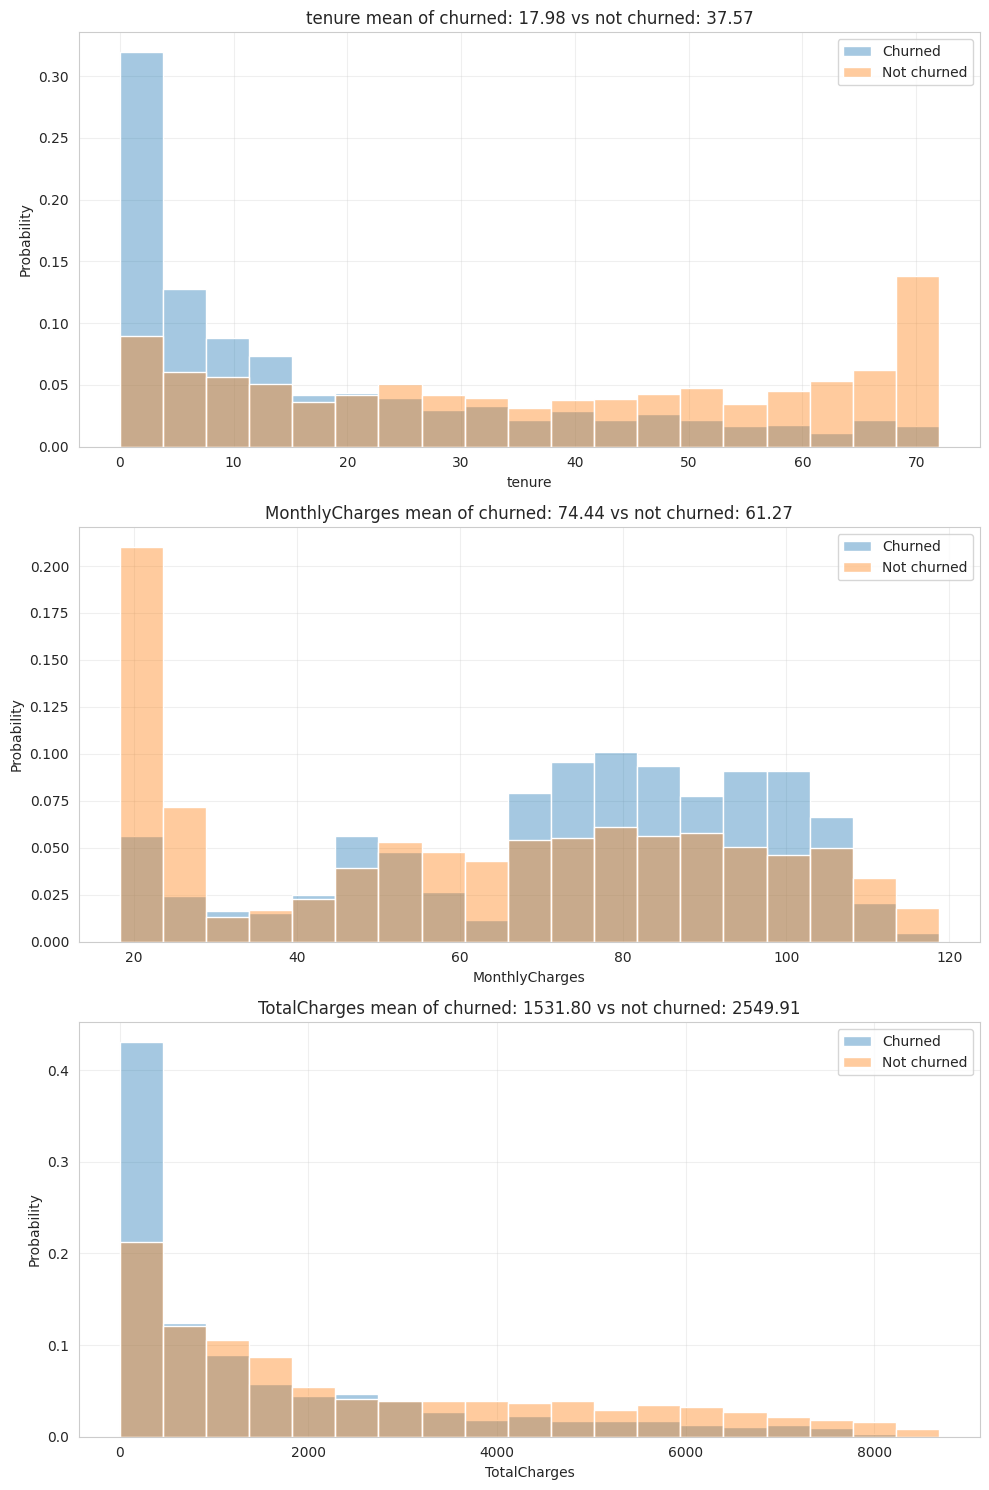

In [19]:
num_features = len(numeric_features)
fig, axes = plt.subplots(num_features, 1, figsize=(10, 5 * num_features))

is_churned_sample = dt_casted_lf.filter(pl.col("is_churned"))
not_churned_sample = dt_casted_lf.filter(~pl.col("is_churned"))

is_churned_means = is_churned_sample.select(numeric_features).mean().collect()
not_churned_means = not_churned_sample.select(numeric_features).mean().collect()

for feature, ax in zip(numeric_features, axes):

    is_churned_feature = is_churned_sample.select(feature).collect()
    not_churned_feature = not_churned_sample.select(feature).collect()

    min_val = dt_casted_lf.select(feature).min().collect().item()
    max_val = dt_casted_lf.select(feature).max().collect().item()
    bins = np.linspace(min_val, max_val, 20)

    sns.histplot(
        data=is_churned_feature, x=feature, stat="probability", alpha=0.4, ax=ax, label="Churned", bins=bins
    )
    sns.histplot(
        data=not_churned_feature, x=feature, stat="probability", alpha=0.4, ax=ax, label="Not churned", bins=bins
    )

    # ax.set_title(f'Relationship between {feature} and Churn')
    ax.set_title(
        f"{feature} mean of churned: {is_churned_means[feature].item():.2f} "
        f"vs not churned: {not_churned_means[feature].item():.2f}"
    )
    ax.legend()
    ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


According to the histograms above, I assume that churned clients:
1. have lower tenure;
2. have higher monthly paycheck;
3. have lower charges in total.

Let's check these hypothesises.

In [20]:
def mwu_test(feature: str, alternative: str) -> MannwhitneyuResult:
    """Perform Mann-Whitney U test to compare the distribution of a feature between churned and not churned users.

    Args:
        feature: Name of the feature to compare
        alternative: Direction of the test ('less' or 'greater')

    Returns:
        MannwhitneyuResult: Result of the test
    """
    x = is_churned_sample.select(feature).collect().to_series()
    y = not_churned_sample.select(feature).collect().to_series()
    return mannwhitneyu(x, y, alternative=alternative)

mwu_res = mwu_test("tenure", "less")
print(f"Churned users have lower tenure with p-value {mwu_res.pvalue:.2f}: {mwu_res.pvalue < 0.05}")

mwu_res = mwu_test("MonthlyCharges", "greater")
print(f"Churned users have higher monthly charges with p-value {mwu_res.pvalue:.2f}: {mwu_res.pvalue < 0.05}")

mwu_res = mwu_test("TotalCharges", "less")
print(f"Churned users have lower total charges with p-value {mwu_res.pvalue:.2f}: {mwu_res.pvalue < 0.05}")

Churned users have lower tenure with p-value 0.00: True
Churned users have higher monthly charges with p-value 0.00: True
Churned users have lower total charges with p-value 0.00: True


Seems like our hypothesis' are right and we can use these variables to predict the churn.

I assume, that total charges >= monthly_charges * tenure. The overhead are some situational purchases. These purchases can impact churn.

statistic,TotalCharges
str,f64
"""count""",7043.0
"""null_count""",0.0
"""mean""",0.152953
"""std""",67.202778
"""min""",-370.85
"""25%""",-28.6
"""50%""",0.0
"""75%""",28.5
"""max""",373.25


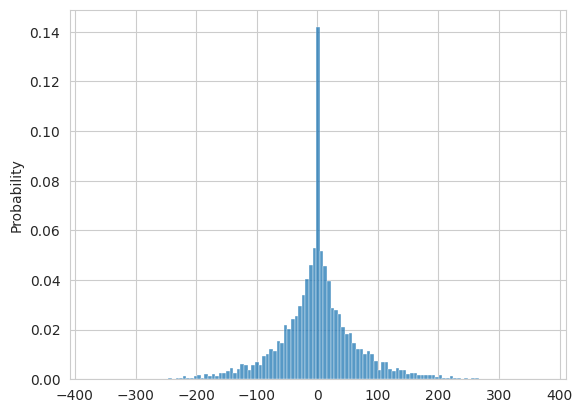

In [21]:
theoretical_total_charges = pl.col("MonthlyCharges") * pl.col("tenure")
extra_charges = dt_casted_lf.select(pl.col("TotalCharges") - theoretical_total_charges)
display(extra_charges.describe())

sns.histplot(extra_charges.collect().to_series(), stat="probability")
plt.show()

Seems like TotalCharges is MonthlyCharges * tenure + random noise. The random noise has normal distribution with mean = 0 and standard deviation = 67.

I think it would be usefull to add TheoreticalTotalCharges into the dataset to reduce probable random noise.

In [22]:
dt_casted_lf = dt_casted_lf.with_columns(theoretical_total_charges.alias("TheoreticalTotalCharges"))
dt_casted_lf.collect().head()

tenure,Contract,PaymentMethod,MonthlyCharges,TotalCharges,is_male,has_partner,has_dependents,has_phone_service,is_paperless_billing,is_churned,is_senior_citizen,has_internet_service,has_multiple_lines,is_fiber,has_online_security,has_online_backup,has_device_protection,has_tech_support,has_streaming_tv,has_streaming_movies,TheoreticalTotalCharges
i64,cat,cat,f64,f64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,f64
1,"""Month-to-month""","""Electronic check""",29.85,29.85,false,true,false,false,true,false,false,true,false,false,false,true,false,false,false,false,29.85
34,"""One year""","""Mailed check""",56.95,1889.5,true,false,false,true,false,false,false,true,false,false,true,false,true,false,false,false,1936.3
2,"""Month-to-month""","""Mailed check""",53.85,108.15,true,false,false,true,true,true,false,true,false,false,true,true,false,false,false,false,107.7
45,"""One year""","""Bank transfer (automatic)""",42.3,1840.75,true,false,false,false,false,false,false,true,false,false,true,false,true,true,false,false,1903.5
2,"""Month-to-month""","""Electronic check""",70.7,151.65,false,false,false,true,true,true,false,true,false,true,false,false,false,false,false,false,141.4


### Categorical Features
Analyze categorical features distribution.

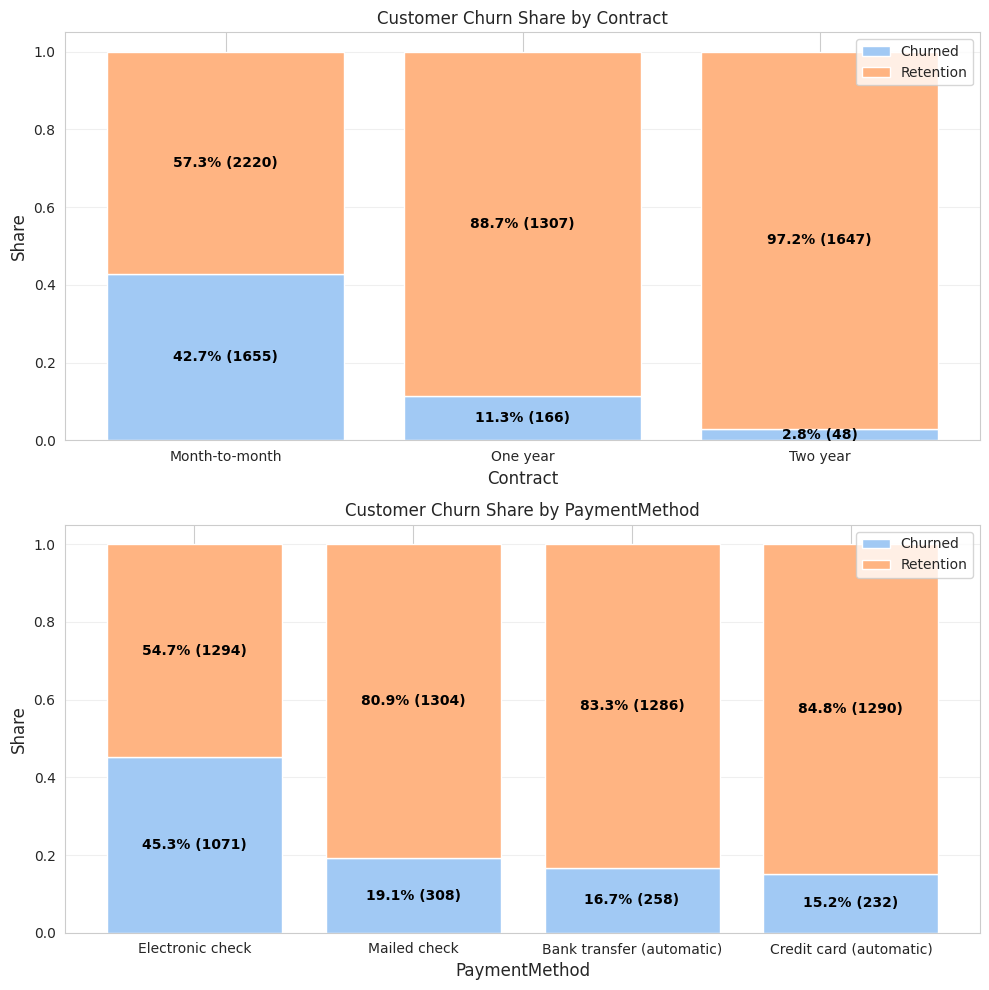

In [23]:
cat_features = ["Contract", "PaymentMethod"]
num_features = len(cat_features)
fig, axes = plt.subplots(num_features, 1, figsize=(10, 5 * num_features))

for feature, ax in zip(cat_features, axes):
    is_churned = (
        dt_casted_lf
        .group_by(feature)
        .agg(
            pl.col("is_churned").mean().alias("churn_share"),
            (1 - pl.col("is_churned")).mean().alias("retention_share"),
            pl.col("is_churned").sum().alias("churn_count"),
            (pl.col("is_churned").count() - pl.col("is_churned").sum()).alias("retention_count")
        )
        .sort(feature)
    )

    feature_data = is_churned.select(feature).collect().to_series()
    churn_data = is_churned.select("churn_share").collect().to_series()
    retention_data = is_churned.select("retention_share").collect().to_series()

    colors = sns.color_palette("pastel")
    ax.bar(feature_data, churn_data, label="Churned", color=colors[0])
    ax.bar(feature_data, retention_data, bottom=churn_data, label="Retention", color=colors[1])

    # Customize the plot
    ax.set_ylabel("Share", fontsize=12)
    ax.set_xlabel(feature, fontsize=12)
    ax.set_title(f"Customer Churn Share by {feature}")
    ax.legend(loc="upper right")
    ax.grid(axis="y", alpha=0.3)

    text_cols = ["churn_share", "retention_share", "churn_count", "retention_count"]
    churn_iter = is_churned.select(text_cols).collect().iter_rows()
    for i, (churn, retention, churn_count, retention_count) in enumerate(churn_iter):
        ax.text(i, churn/2, f"{churn:.1%} ({churn_count})",
                ha="center", va="center", fontweight="bold", color="black")
        ax.text(i, churn + retention/2, f"{retention:.1%} ({retention_count})",
                ha="center", va="center", fontweight="bold", color="black")

plt.tight_layout()
plt.show()

1. The longer contract, the lower churn probability.
2. Customers who payed by electronic check are more likely to churn thatn the others. I will consider adding `is_automatic` feature.

### Boolean features
Plot the relationship between boolean features and churn

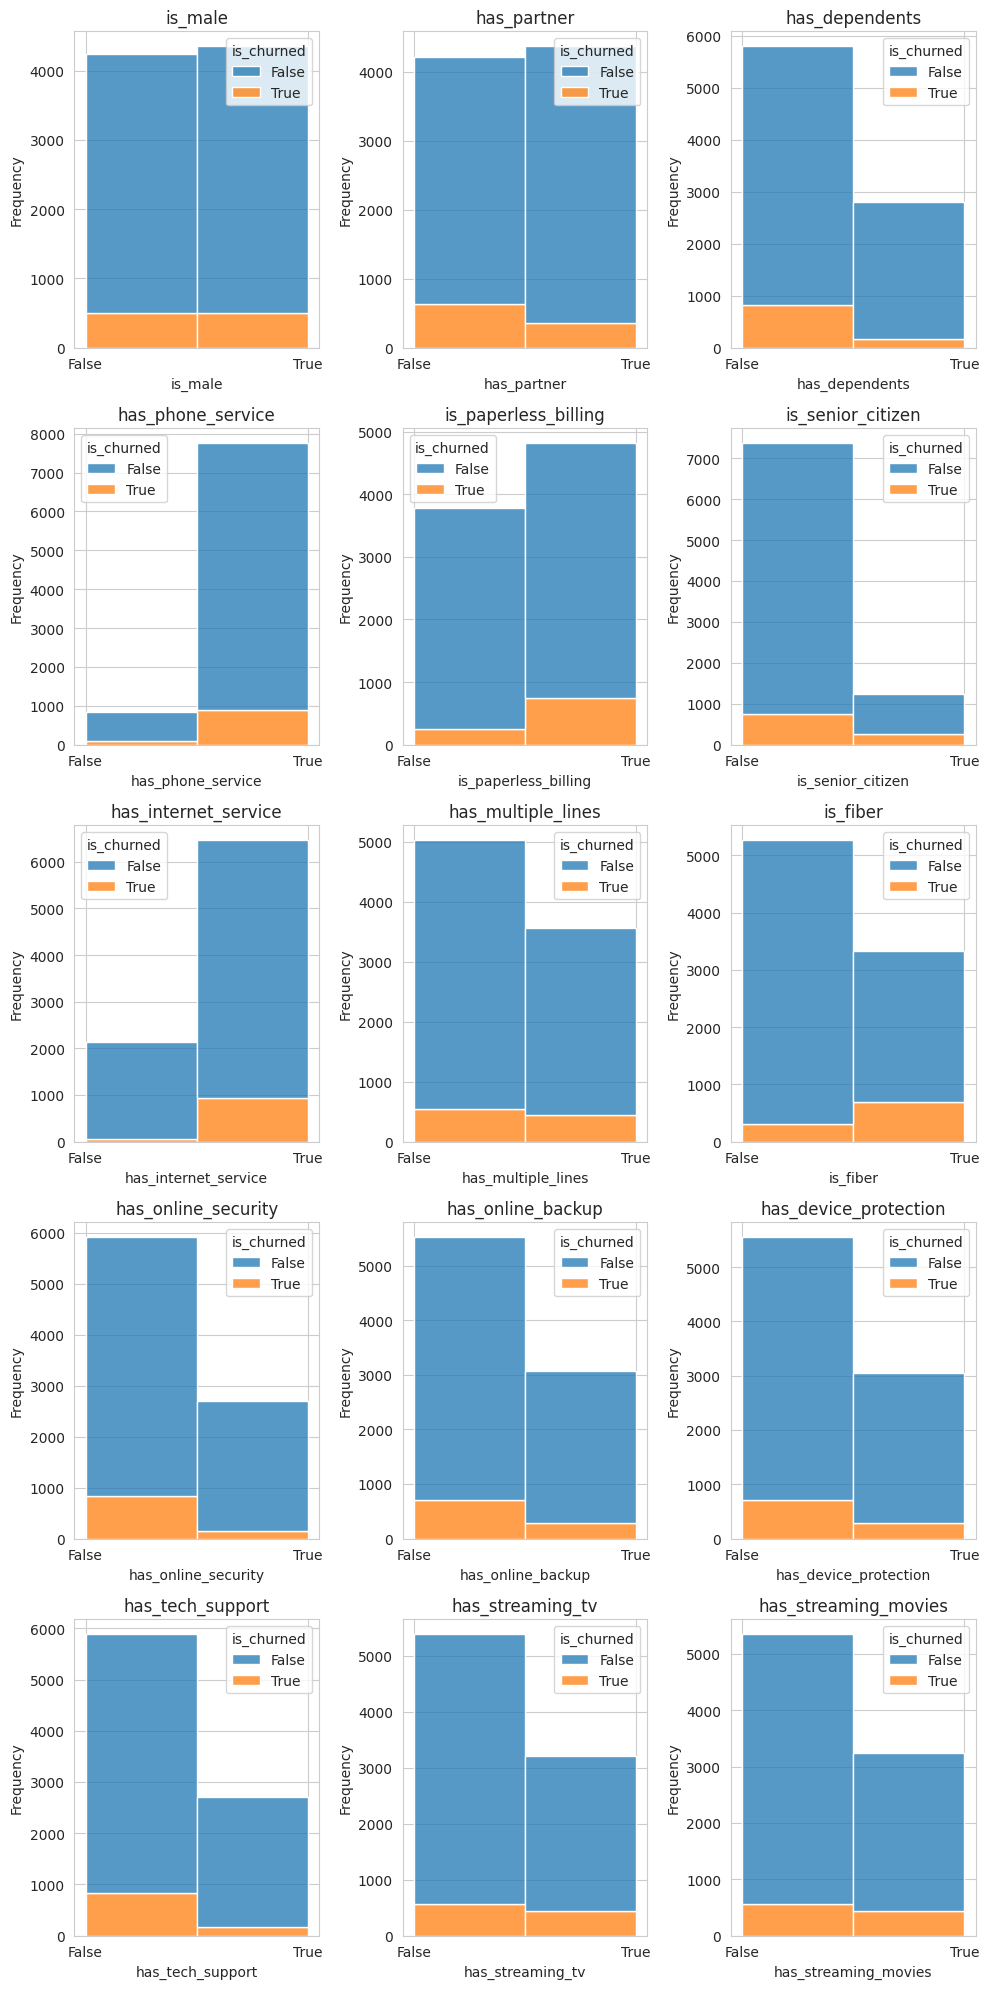

In [24]:
bool_features = [
    name for name, dtype in dt_casted_lf.collect_schema().items()
    if dtype == pl.Boolean and name != "is_churned"
]
num_features = len(bool_features)
col_num = 3
row_num = num_features / col_num
row_num = int(row_num) if row_num % 1 == 0 else int(row_num) + 1
fig, axes = plt.subplots(row_num, col_num, figsize=(10, 4 * row_num))
axes = axes.flatten()[:num_features]

for feature, ax in zip(bool_features, axes):
    sns.histplot(
        data=dt_casted_lf.select(feature, "is_churned").collect(),
        x=feature,
        hue="is_churned",
        multiple="stack",
        stat="frequency",
        binwidth=0.4,
        ax=ax,
    )
    ax.set_xticks([0, 1], ["False", "True"])
    ax.set_title(f"{feature}")

plt.tight_layout()
plt.show()

Correlation analysis for numeric features

Feature importance analysis using chi-square test for categorical features

## Summary of EDA key findings
#### The dataset has imbalanced class distribution.
73.5% non-churned vs 26.5% churned customers. That can cause model bias toward the majority class. To avoid that, I can try one of the next approaches:
1. oversampling the minority class;
2. undersampling the majority class;
3. class weights;
4. threshold adjustment with precision-recall curve;
5. ensemble methods;
6. anomaly detection approach.

Futhermore, I can't use accuracy to access the model's quality.
Applicable metrics: precision+recall, f1-score, ROC-AUC.

#### Variables dependencies
Churned clients tend to :
1. have lower tenure;
2. have higher monthly paycheck;
3. have lower charges in total.

These findings should be taken into account during the modelling phase.